### Sketching technique: Regression : l2 norm ratio 
#### Leverage score
#### Kmeans (Local Landmark Selection)
#### Kmeans++ (probablistic || parallel KMeans++)
#### Time taken by each algorithm
#### Uniform Sampling

## ------------------------------------

#### Few important libraries
###### sklearn.utils.extmath.randomized_svd


#### ----------------------------------------
##### axis = 0 across columns
##### axis = 1/-1 across row
##### np.sum(np.abs(x)**2,axis=-1/1) for computing l2norm of each row of matrix

### Citation

##### Enzo Michelangeli, style changes by josef-pktd code for multivariate t ditribution is used : found on stack overflow : https://stackoverflow.com/questions/41957633/sample-from-a-multivariate-t-distribution-python


### Synthetic Data Creation
#### Reference page15: https://arxiv.org/pdf/1306.5362.pdf


##### 1.Nearly uniform leverage scores (GA)
##### 2.Moderately nonuniform leverage scores (T3).
##### 3.Very nonuniform leverage scores (T1)

#### Library Imports

In [ ]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit,time
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#### Execution : Nearly Uniform Leverage Score

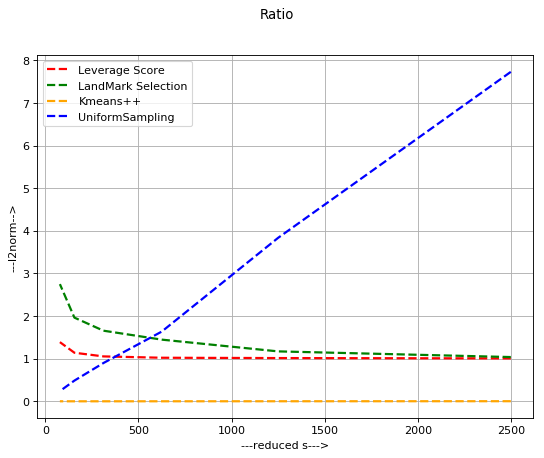

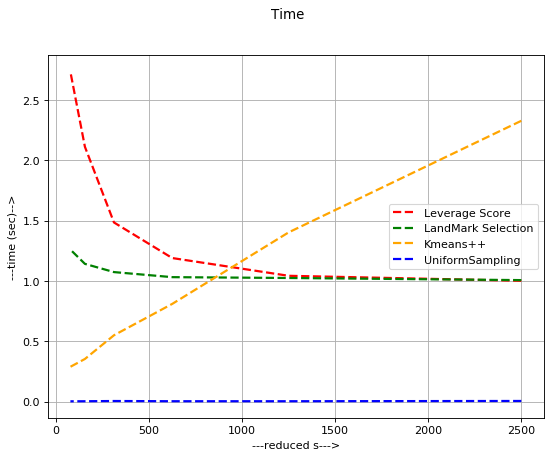

In [573]:
#%time
n = int(input('Enter the column dimension (# fo row): '))
d = int(input('Enter the row dimension(# of column > 20): '))
#name = input('Enter the sketching technique: ')

##-----------------------------------------------------------##
A,b = syntheticData(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
row,col = A.shape
s = [row/2,row/4,row/8,row/16,row/32,row/64]
s = [round(x) for x in s]
r1,t1,r2,t2,r3,t3,r4,t4 = controller2(A,b)
plots(s,r1,r2,r3,r4,'Ratio')
plots(s,t1,t2,t3,t4,'Time')

#### Execution : Moderaltely Uniform Leverage Score

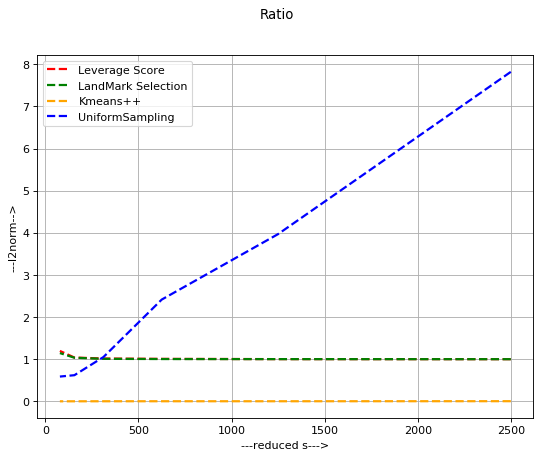

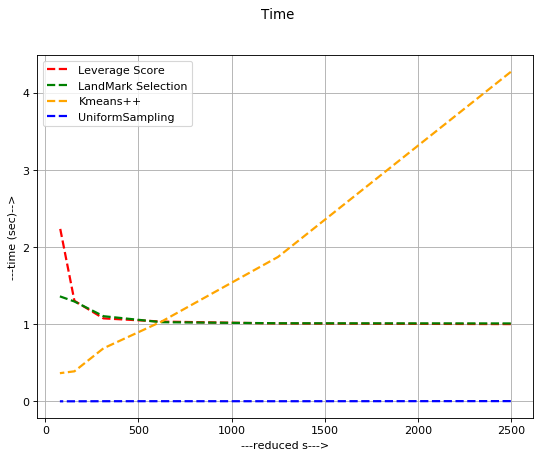

In [574]:
n = int(input('Enter the column dimension (# fo row): '))
d = int(input('Enter the row dimension(# of column > 20): '))

##-----------------------------------------------------------##
A,b = T3(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
row,col = A.shape
s = [row/2,row/4,row/8,row/16,row/32,row/64]
s = [round(x) for x in s]
#controller(A,b,name)
r1,t1,r2,t2,r3,t3,r4,t4 = controller2(A,b)
#r1,r2,r3,r4 = controller2(A,b)
plots(s,r1,r2,r3,r4,'Ratio')
plots(s,t1,t2,t3,t4,'Time')

#### Execution : Very Non-Uniform Leverage Score

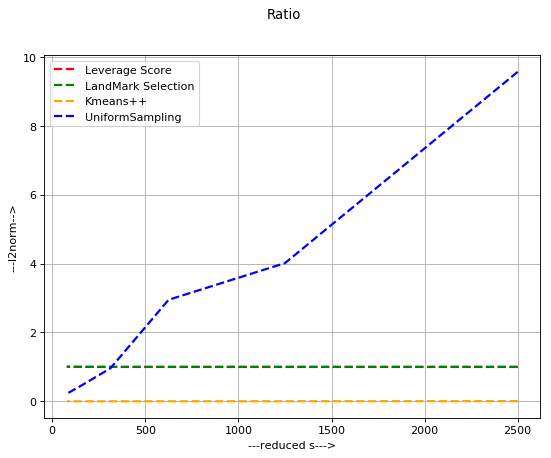

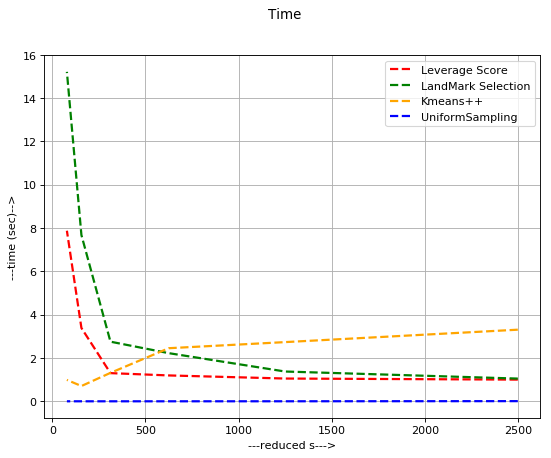

In [575]:
n = int(input('Enter the column dimension (# fo row): '))
d = int(input('Enter the row dimension(# of column > 20): '))

##-----------------------------------------------------------##
A,b = T1(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
row,col = A.shape
s = [row/2,row/4,row/8,row/16,row/32,row/64]
s = [round(x) for x in s]
#controller(A,b,name)
r1,t1,r2,t2,r3,t3,r4,t4 = controller2(A,b)
#r1,r2,r3,r4 = controller2(A,b)
plots(s,r1,r2,r3,r4,'Ratio')
plots(s,t1,t2,t3,t4,'Time')

#### Controller

In [ ]:
def controller(A,b,name):
    if name == 'lss':
        LSS(A,b)
    elif name=='kpp':
        Kpp(A,b)
    elif name == 'lms':
        LMS(A,b)
    elif name == 'uss':
        USS(A,b)

In [ ]:
def controller2(A,b):
    r1,t1 = LSS(A,b)
    r2,t2 = LMS(A,b)
    r3,t3 = KPP(A,b)
    r4,t4 = USS(A,b)
    return r1,r2,r3,r4,t1,t2,t3,t4

##### Leverage Score Sampling

In [561]:
def LSS(A,b):
    l2norm=list() #for storing l2 norm across various size changes
    ratio = list()
    t =list()
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.abs(u)**2,axis=1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    for i in s:
        start = time.time()
        index = np.random.choice(row,i,replace = False,p=prob)
        C = A[index,:] # selcting s rows
        A_sketch = C
        b_sketch = b[index]
    #-------------- calling regression function -----------#
        x_tilde = regression(A_sketch,b_sketch)
        end = time.time() # time is only calculated for find approximate x
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        t.append(end-start)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio,t
    #plotting(s,ratio,t,'Leverage Score Sampling')

##### LandMark Sampling Selection

In [572]:
def LMS(A,b):
    l2norm = list()  # this is for sketched
    ratio = list()
    t=list()
    aug_A = np.c_[A,b]
    for i in s:
        start = time.time()
        k_cluster=KMeans(n_clusters=i,init='random',n_init=1,random_state=0).fit(aug_A)
        C = k_cluster.cluster_centers_
        A_sketch = C[:,:-1] # placing the first d columns in A sketch
        b_sketch = C[:,-1]  #placing the (d+1)th column in b
        x_tilde = regression(A_sketch,b_sketch)        
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        end = time.time()
        t.append(end-start) # only for sketched matrix
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio,t
    #plotting(s,ratio,t,'Local Landmark Selection')

##### KMeans ++ Sampling
###### class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm=’auto’)[source]

In [571]:
def KPP(A,b):
    l2norm = list()  # this is for sketched
    ratio = list()
    t=list()
    aug_A = np.c_[A,b]
    for i in s:
        start=time.time()
        k_cluster=KMeans(n_clusters=i,init='k-means++',n_init=1,random_state=0).fit(aug_A)
        C = k_cluster.cluster_centers_
        A_sketch = C[:,:-1] # placing the first d columns in A sketch
        b_sketch = C[:,-1]#placing the (d+1)th column in b
        x_tilde = regression(A_sketch,b_sketch)        
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        end=time.time()
        t.append(end-start)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio,t
    #plotting(s,ratio,t,'KMeans++')

##### Uniform Sampling

In [569]:
def USS(A,b):
    l2norm = list()  # this is for sketched
    ratio = list()
    t=list()
    s = [row/2,row/4,row/8,row/16,row/32,row/64]
    s = [round(x) for x in s]
    for i in s:
        start = time.time()
        index = np.random.choice(row,i)
        A_sketch = A[index,:]# called C also
        b_sketch = b[index]
        x_tilde = regression(A_sketch,b_sketch)
        end = time.time() 
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        end = time.time()
        t.append(end-start)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio,t
    #plotting(s,ratio,t,'Uniform Sampling')

##### Regression Model

In [ ]:
def regression(A,b):
    regression_model = LinearRegression()
    regression_model.fit(A,b)
    #x_tilde=regression_model.coef_
    return regression_model.coef_

##### Plotting

In [ ]:

def plotting(x,r,t,name):
    # Create a figure of size 8x6 inches, 80 dots per inch
    plt.figure(figsize=(8, 6), dpi=80)
    # Create a new subplot from a grid of 1x1
    plt.subplot(2, 1, 1)
    #plt.plot(x, y1, color="blue", linewidth=1.5, linestyle="--",label='Approximated weight')
    #plt.plot(x,y2,color="red",linewidth=1.5,linestyle="--",label='Optimal Weight')
    plt.plot(x,r,color="green",linewidth=2.5,linestyle=":",label='Ratio: Approx / Opt')
    plt.legend()
    plt.grid(b=True)
    plt.ylabel('--l2 norm-->')
    plt.xlabel('--Reduced s-->')

    plt.subplot(2,1,2)
    plt.plot(x,t,color="orange",linewidth = 1.5,linestyle="--",label='WallClock time for approx. x')
    plt.ylabel('--time elapsed in sec-->')
    plt.xlabel('--Reduced s-->')
    plt.grid(b=True)
    plt.legend()
    plt.suptitle(name)
    plt.show()


In [560]:
def plots(x,y1,y2,y3,y4,title):
    plt.figure(figsize=(8,6),dpi=80)
    plt.plot(x,y1,color="red",linewidth=2.0,linestyle="--",label='Leverage Score')
    plt.plot(x,y2,color="green",linewidth=2.0,linestyle="--",label='LandMark Selection')
    plt.plot(x,y3,color="orange",linewidth=2.0,linestyle="--",label='Kmeans++')
    plt.plot(x,y4,color="blue",linewidth=2.0,linestyle="--",label='UniformSampling')
    plt.xlabel('---reduced s--->')
    if title == 'Ratio':
        plt.ylabel('---l2norm-->')
    else:
        plt.ylabel('---time (sec)-->')
    plt.legend()
    plt.grid(b=True)
    plt.suptitle(title)
    plt.show()

#### Synthetic data : uniform leverage score
##### y = Xw+e
##### Using multivariate distribution : N(1d,C)
##### C = 2*0.5^|i-j|  : covariance matrix
##### w =(1_10;0.1*1_p-20;1_10)_p


In [565]:
## create a dxd covariance matrix
def GA(n,d):
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    X = np.random.multivariate_normal(mean,C,(n)) # this is A
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

#### Synthetic Data : Moderaltely non-uniform leverage score

In [ ]:
def T3(n,d):
    df = 3
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    
    return X,y
    
    

#### Synthetic Data : Very non-uniform leverage score

In [564]:
def T1(n,d):
    df = 1
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    
    return X,y